In [1]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools

### Initial data
#### Demand for labor

In [2]:
demand_for_labor = \
    [[0, 0],
     [1, 0],
     [2, 0],
     [3, 0],
     [4, 0],
     [5, 0],
     [6, 0],
     [7, 0],
     [8, 0],
     [9, 2],
     [10, 4],
     [11, 4],
     [12, 3],
     [13, 2],
     [14, 3],
     [15, 4],
     [16, 5],
     [17, 6],
     [18, 6],
     [19, 6],
     [20, 6],
     [21, 3],
     [22, 2],
     [23, 2]]
demand_for_labor_df = pd.DataFrame(demand_for_labor, columns = ['hour', 'number'])

#### The duration of the shift staff

In [3]:
workers = \
    [['Alan', 8],
     ['Antony', 8],
     ['Bob', 4],
     ['Emma', 12],
     ['Logan', 12],
     ['Sophia', 12],
     ['Abigail', 12]]
workers_df = pd.DataFrame(workers, columns = ['worker', 'shift_duration'])

#### Staff costs

In [4]:
# costs per man-shift
staff_costs_per_shift = 100
# costs per man-hour in addition to costs per man-shift
staff_costs_per_hour = 25

#### Plots

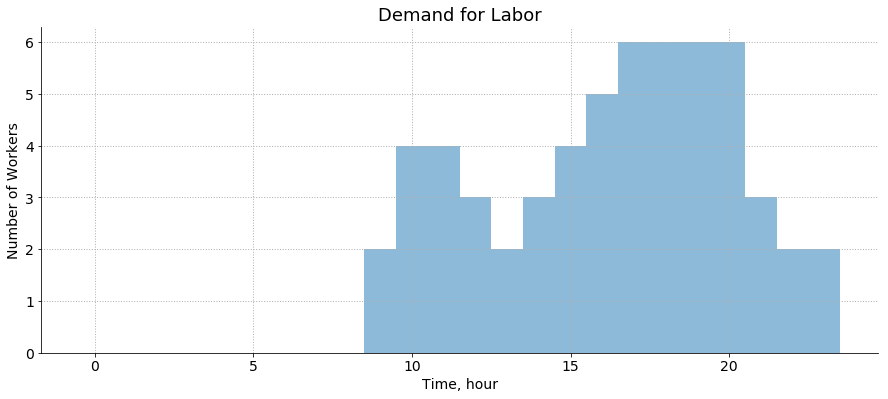

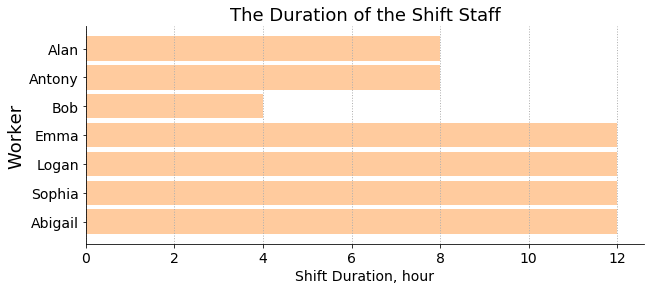

Demand for labor: 58 man-hours
Available labor:  68 man-hours


In [5]:
# Demand for Labor plot
mpl.rcParams['figure.figsize'] = (15.0, 6.0)
plt.bar(demand_for_labor_df.hour, demand_for_labor_df.number, width=1, alpha=0.5)
plt.xlabel('Time, hour', fontsize=14)
plt.ylabel('Number of Workers', fontsize=14)
plt.title('Demand for Labor', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(linestyle=':', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
plt.show()

# The duration of the Shift Staff plot
mpl.rcParams['figure.figsize'] = (10.0, 4.0)
plt.barh(workers_df.worker, workers_df.shift_duration, height=0.85, left=0, color='C1', alpha=0.4)
plt.xlabel('Shift Duration, hour', fontsize=14)
plt.ylabel('Worker', fontsize=18)
plt.title('The Duration of the Shift Staff', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(axis='x', linestyle=':', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.invert_yaxis() 

plt.show()

print(f'Demand for labor: {sum(demand_for_labor_df.number)} man-hours')
print(f'Available labor:  {sum(workers_df.shift_duration)} man-hours')

### Creating auxiliary variables

#### Possible shifts

In [6]:
possible_shifts_list= \
     [{'worker':worker,  'hour_start':hour, 'hour':hour+l, 'working':True} 
       for worker in workers_df.worker.values
       for hour in demand_for_labor_df.hour.values
       for l in range(workers_df[workers_df.worker==worker].shift_duration.values[0])
      ]
possible_shifts = pd.DataFrame(possible_shifts_list)

#### Worker index

In [7]:
worker_index = [(worker, hour) for hour in demand_for_labor_df.hour.values for worker in workers_df.worker.values]

#### Adding workers start variables

In [8]:
workers_start = pulp.LpVariable.dicts("workers_start",
                                      ((worker, hour) for hour in demand_for_labor_df.hour.values for worker in workers_df.worker.values),
                                      lowBound=0,
                                      cat='Binary')

#### Adding workers status variables

In [9]:
worker_status = pulp.LpVariable.dicts("worker_status",
                                      (worker for worker in workers_df.worker.values),
                                      cat='Binary')

#### Cost minimising scheduling problem

In [10]:
model = pulp.LpProblem("Cost minimising scheduling problem", pulp.LpMinimize)
model += pulp.lpSum(
      [workers_start[worker, hour] * staff_costs_per_hour * workers_df[workers_df.worker==worker].shift_duration.values[0] for worker, hour in worker_index]
    + [worker_status[worker] * staff_costs_per_shift for worker in workers_df.worker.values]
      )

#### Adding the hard condition on the availability of staff in every hour during the day

In [11]:
for hour_item in range(24):
    model += \
        pulp.lpSum([possible_shifts[(possible_shifts.worker==worker) & \
                             (possible_shifts.hour_start==hour) & \
                             (possible_shifts.hour==hour_item)].working.values[0]*\
             workers_start[worker, hour]
             for hour, worker in possible_shifts[possible_shifts.hour==hour_item][['hour_start', 'worker']].values])\
        >= demand_for_labor_df[demand_for_labor_df.hour==hour_item].number.values[0]

#### Adding the hard condition on the number of employees

In [12]:
for worker in workers_df.worker.values:
    model += \
        pulp.lpSum([workers_start[worker, hour] for hour in range(24)])<=\
        worker_status[worker]
    model += \
        worker_status[worker]<=1

### Solving
#### Model Status and Minimum Cost

In [13]:
model.solve()
print(f'Model Status: {pulp.LpStatus[model.status]}')
print(f'Minimum Cost: {pulp.value(model.objective)}')

Model Status: Optimal
Minimum Cost: 2200.0


#### Optimal shifts

In [14]:
output = []
for worker, hour in workers_start:
    if workers_start[(worker, hour)].varValue>0 and worker_status[(worker)].varValue>0:
        var_output = {
            'worker': worker,
            'start_hour': hour,
            'workers_start': workers_start[(worker, hour)].varValue,
            'worker_status': worker_status[(worker)].varValue
        }
        output.append(var_output)

output_df = pd.DataFrame(output).sort_values('worker')
output_df

,start_hour,worker,worker_status,workers_start
3,10,Abigail,1.0,1.0
4,16,Alan,1.0,1.0
5,16,Antony,1.0,1.0
2,10,Emma,1.0,1.0
0,9,Logan,1.0,1.0
1,9,Sophia,1.0,1.0


#### Preprocessing for plotting

In [15]:
workers_result_df = workers_df.merge(output_df,
                                     how='outer',
                                     on='worker').fillna(0)
workers_result_df = workers_result_df[workers_result_df.worker_status==1]

In [16]:
working_hours_list =  \
    [list(workers_result_df.loc[index, 'start_hour']+list(range(workers_result_df.loc[index, 'shift_duration']))) 
     for index in workers_result_df.index]
working_hours_list = [item for sublist in working_hours_list for item in sublist]
unique_elements, counts_elements = np.unique(working_hours_list, return_counts=True)
working_hours_df = pd.DataFrame({'hour':unique_elements, 'number_exist':counts_elements})

In [17]:
demand_and_predict_for_labor_df = demand_for_labor_df.merge(
                                      working_hours_df,
                                      how='left',
                                      on='hour').fillna(0)

#### Plots

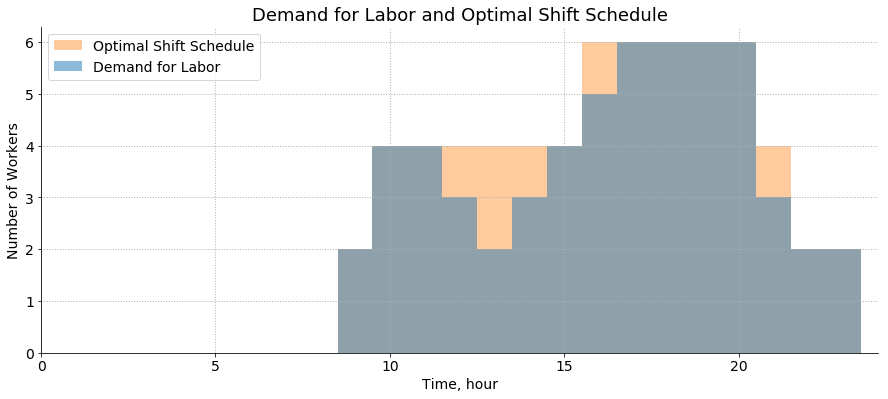

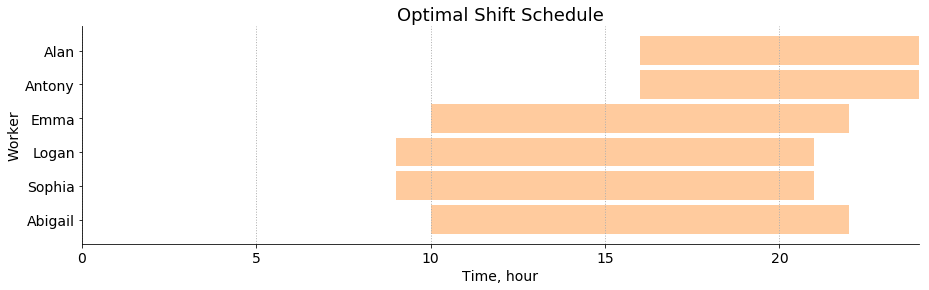

Demand for labor: 58 man-hours
Available labor:  68 man-hours
Optimal labor:    64 man-hours


In [18]:
# Demand for Labor and Optimal Shift Schedule plot
mpl.rcParams['figure.figsize'] = (15, 6.0)
plt.bar(demand_and_predict_for_labor_df.hour, 
        demand_and_predict_for_labor_df.number_exist, 
        width=1, 
        color='C1',
        alpha=0.4)
plt.bar(demand_and_predict_for_labor_df.hour, 
        demand_and_predict_for_labor_df.number, 
        width=1, 
        alpha=0.5)
plt.xlabel('Time, hour', fontsize=14)
plt.ylabel('Number of Workers', fontsize=14)
plt.title('Demand for Labor and Optimal Shift Schedule', fontsize=18)
plt.legend(['Optimal Shift Schedule','Demand for Labor'],loc=2, fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid( linestyle=':', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_xlim(0,24)
plt.show()

# Optimal Shift Schedule plot
mpl.rcParams['figure.figsize'] = (15.0, 4.0)
plt.barh(workers_result_df.worker, 
         workers_result_df.shift_duration, 
         height=0.85, 
         left=workers_result_df.start_hour,
         color='C1',
         alpha=0.4)
plt.xlabel('Time, hour', fontsize=14)
plt.ylabel('Worker', fontsize=14)
plt.title('Optimal Shift Schedule', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(axis='x', linestyle=':', linewidth=1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_xlim(0,max(workers_result_df.shift_duration+workers_result_df.start_hour))
ax.invert_yaxis() 

plt.show()

print(f'Demand for labor: {sum(demand_for_labor_df.number)} man-hours')
print(f'Available labor:  {sum(workers_df.shift_duration)} man-hours')
print(f'Optimal labor:    {sum(workers_result_df.shift_duration)} man-hours')